In [9]:
artnet_data_path = "/content/drive/MyDrive/Colab Notebooks/neurolumen/Techno_intensity3/artnet_data.json"
wav1_path = "/content/drive/MyDrive/Colab Notebooks/neurolumen/Techno_intensity3/240216_225329_53.wav"
wav2_path = "/content/drive/MyDrive/Colab Notebooks/neurolumen/Techno_intensity3/240217_010846_08.wav"

In [2]:
!pip install pydub

In [3]:
import pandas as pd
import numpy as np
import librosa
import json
import matplotlib.pyplot as plt
import librosa.display
from pydub import AudioSegment
import pandas as pd
import numpy as np
import librosa
import ast

In [10]:
data_list = []

with open(artnet_data_path, "r") as f:
  for line in f:
        data = json.loads(line.strip())
        data_list.append(data)



In [13]:
df = pd.DataFrame(data_list)

df['t'] = pd.to_datetime(df['t'])

# Set the timestamp as the index
df.set_index('t', inplace=True)

# Resample the data at 50 millisecond intervals using forward fill to handle gaps
# resampled_data = df.resample('50L').ffill().fillna(0)
resampled_data = df.resample('50L').ffill().dropna()

start_time = resampled_data.index[0]

# Subtract the start time from each timestamp to get the delta in milliseconds
time_deltas_ms = (resampled_data.index - start_time).total_seconds() * 1000

# Add this as a new column to the DataFrame
resampled_data['diff'] = time_deltas_ms

resampled_data = resampled_data.head(10000)

In [14]:
audio = AudioSegment.from_file(wav1_path, format="wav")

sample_rate = audio.frame_rate

# Time intervals in milliseconds
time_intervals = resampled_data['diff'].values # Extend this list as needed

# Convert time intervals from milliseconds to sample indices
sample_intervals = [int(sample_rate * (t / 1000.0)) for t in time_intervals]

target_samples = 512

df_list = []

# Process each segment and extract MFCCs
# for i in range(5):
for i in range(len(sample_intervals) - 1):
    start_sample = sample_intervals[i]
    end_sample = sample_intervals[i + 1]

    n_fft = 512
    hop_length = 128
    n_mfcc = 40

    segment = audio[start_sample:end_sample]

    # Convert pydub audio segment to normalized audio samples array
    samples = np.array(segment.get_array_of_samples())
    # Normalize to float32 between -1.0 and 1.0 for librosa compatibility
    if segment.sample_width == 2:  # 2 bytes = 16 bit
        samples = samples.astype(np.float32) / 2**15  # 16-bit PCM is max at 2^15
    elif segment.sample_width == 4:  # 4 bytes = 32 bit
        samples = samples.astype(np.float32) / 2**31  # 32-bit PCM is max at 2^31

    if len(samples) < target_samples:
        samples = np.pad(samples, (0, target_samples - len(samples)), 'constant')
    else:
        samples = samples[:target_samples]

    mfcc = librosa.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    temp_df = pd.DataFrame({
        "MFCC": [mfcc],
        "Start_ms": [time_intervals[i]],
        "End_ms": [time_intervals[i + 1]]
    })

    df_list.append(temp_df)

# Concatenate all DataFrames in the list into one DataFrame
features_df = pd.concat(df_list, ignore_index=True)

print("DataFrame is ready with MFCC features.")
print(features_df.head())


/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


DataFrame is ready with MFCC features.
                                                MFCC  Start_ms  End_ms
0  [[-441.87597018088303, -415.2526681929478, -42...       0.0    50.0
1  [[-465.31249710032836, -442.9439042064751, -44...      50.0   100.0
2  [[-365.2345500046884, -355.77972936361044, -37...     100.0   150.0
3  [[-406.66625685843997, -399.1299481006533, -42...     150.0   200.0
4  [[-360.360793021917, -361.3964033889913, -390....     200.0   250.0


In [18]:
features_df

,MFCC,Start_ms,End_ms
0,"[[-441.87597018088303, -415.2526681929478, -42...",0.0,50.0
1,"[[-465.31249710032836, -442.9439042064751, -44...",50.0,100.0
2,"[[-365.2345500046884, -355.77972936361044, -37...",100.0,150.0
3,"[[-406.66625685843997, -399.1299481006533, -42...",150.0,200.0
4,"[[-360.360793021917, -361.3964033889913, -390....",200.0,250.0
...,...,...,...
9994,"[[-1131.370849898476, -1131.370849898476, -113...",499700.0,499750.0
9995,"[[-1131.370849898476, -1131.370849898476, -113...",499750.0,499800.0
9996,"[[-1131.370849898476, -1131.370849898476, -113...",499800.0,499850.0
9997,"[[-1131.370849898476, -1131.370849898476, -113...",499850.0,499900.0


In [19]:
features_df.shape

(9999, 3)

In [20]:
features_df['MFCC'][0].shape

(40, 5)

In [21]:
features_df['MFCC'][9000].shape

(40, 5)

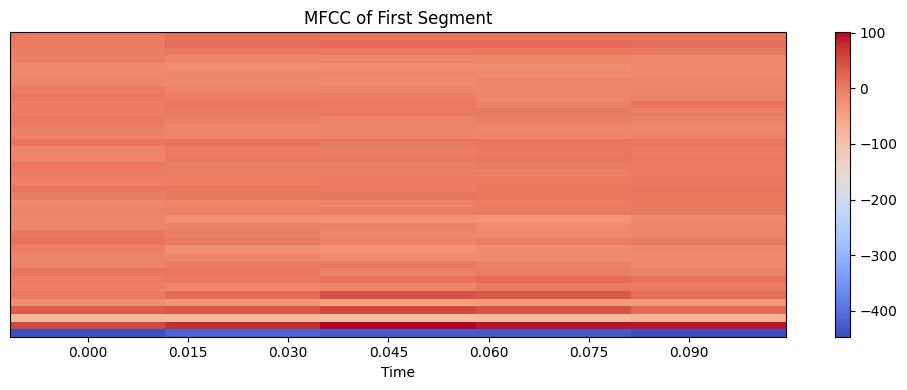

In [22]:
# Function to plot MFCC
def plot_mfcc(mfcc, title="MFCC"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

if not features_df.empty and 'MFCC' in features_df.columns:
    first_mfcc = features_df.iloc[0]['MFCC']
    plot_mfcc(first_mfcc, title="MFCC of First Segment")
else:
    print("DataFrame is invalid.")


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

def custom_vgg16_for_classification(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 1), name='block1_pool')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 1), name='block2_pool')(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)

    x = Dense(num_classes, activation='softmax')(x)  # Softmax for multi-class classification

    model = Model(inputs=input_layer, outputs=x)
    return model

# Example usage
input_shape = (40, 5, 1)
num_classes = 256  # Total number of classes
model = custom_vgg16_for_classification(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 5, 1)]        0         
                                                                 
 block1_conv1 (Conv2D)       (None, 40, 5, 64)         640       
                                                                 
 block1_conv2 (Conv2D)       (None, 40, 5, 64)         36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 20, 5, 64)         0         
                                                                 
 block2_conv1 (Conv2D)       (None, 20, 5, 128)        73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 20, 5, 128)        147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 10, 5, 128)        0   

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

X = features_df['MFCC'].values
y = np.array(resampled_data['val'].values)[1:]

X = np.stack(X, axis=0)
y = np.stack(y, axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = np.array([np.array(yi) if isinstance(yi, list) else yi for yi in y_train])
y_test2 = np.array([np.array(yi) if isinstance(yi, list) else yi for yi in y_test])
y_test = y_test2





In [27]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (7999, 40, 5)
y_train shape: (7999, 512)


In [28]:
features_df['MFCC'][1].shape

(40, 5)

In [30]:
# Check for any elements not matching the expected shape
non_conforming = [x.shape for x in X if x.shape != (40, 5)]
print("Non-conforming shapes found:", set(non_conforming))
print("Number of non-conforming arrays:", len(non_conforming))


Non-conforming shapes found: set()
Number of non-conforming arrays: 0


In [31]:
from tensorflow.keras.utils import to_categorical

# y_train are labels ranging from 0 to 255 of length 512
y_train_encoded = to_categorical(y_train[:, 3], num_classes=256)

# Now y_train_encoded will have the shape (number_of_samples, 256)
# I was thinking to train every light signal (every column of ytrain) separetely

In [ ]:
history = model.fit(
    X_train, y_train_encoded,
    epochs=5000,
    batch_size=2048,
    validation_split=0.4
)


Epoch 1/5000
3/3 [==============================] - 3s 1s/step - loss: 3.1110 - accuracy: 0.4607 - val_loss: 11.7653 - val_accuracy: 0.1675
Epoch 2/5000
3/3 [==============================] - 0s 100ms/step - loss: 3.1107 - accuracy: 0.4607 - val_loss: 11.7448 - val_accuracy: 0.1669
Epoch 3/5000
3/3 [==============================] - 0s 116ms/step - loss: 3.1105 - accuracy: 0.4607 - val_loss: 11.7265 - val_accuracy: 0.1669
Epoch 4/5000
3/3 [==============================] - 0s 120ms/step - loss: 3.1102 - accuracy: 0.4607 - val_loss: 11.7208 - val_accuracy: 0.1663
Epoch 5/5000
3/3 [==============================] - 0s 99ms/step - loss: 3.1101 - accuracy: 0.4607 - val_loss: 11.7186 - val_accuracy: 0.1656
Epoch 6/5000
3/3 [==============================] - 0s 118ms/step - loss: 3.1098 - accuracy: 0.4607 - val_loss: 11.7369 - val_accuracy: 0.1656
Epoch 7/5000
3/3 [==============================] - 0s 104ms/step - loss: 3.1093 - accuracy: 0.4607 - val_loss: 11.7684 - val_accuracy: 0.1669
Epo